In [1]:
import concurrent.futures
import numpy as np
import cv2
import os
import pickle
import face_recognition
import sys
import json
import time

In [2]:
ENCODING_FILE = "encodings_hog/encodings.pkl"
KNOWN_DIR = "known_faces/dataset_imgs"

def encode_image(file):
    try:
        path = os.path.join(KNOWN_DIR, file)
        img = face_recognition.load_image_file(path)
        # Resize for speed
        # img = cv2.resize(img, (0, 0), fx=0.4, fy=0.4)

        # enc = face_recognition.face_encodings(img)
        # if enc:
        #     return enc[0], os.path.splitext(file)[0]
        enc = face_recognition.face_encodings(img)
        if len(enc) == 1:
              return enc[0], os.path.splitext(file)[0]

    except Exception as e:
        print("Skipped:", file)
        return None

# # Load existing encodings
# if os.path.exists(ENCODING_FILE):
#     with open(ENCODING_FILE, "rb") as f:
#         known_faces, known_names = pickle.load(f)
# else:
#     known_faces, known_names = [], []

# # Get all files
# files = [f for f in os.listdir(KNOWN_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]

# # Find new files (not yet in known_names)
# new_files = [f for f in files if os.path.splitext(f)[0] not in known_names]

# for file in new_files:
#     path = os.path.join(KNOWN_DIR, file)
#     img = face_recognition.load_image_file(path)
#     enc = face_recognition.face_encodings(img)
#     if enc:
#         known_faces.append(enc[0])
#         known_names.append(os.path.splitext(file)[0])

# # Save updated encodings
# with open(ENCODING_FILE, "wb") as f:
#     pickle.dump((known_faces, known_names), f)

# print(f"✅ Added {len(new_files)} new images to encodings.pkl")

def load_known_faces():
    if os.path.exists(ENCODING_FILE):
        with open(ENCODING_FILE, "rb") as f:
            return pickle.load(f)

    files = [f for f in os.listdir(KNOWN_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]

    known_faces = []
    known_names = []

    print(f"⚡ Encoding {len(files)} images using threads...")

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(encode_image, files)

        for res in results:
            if res:
                known_faces.append(res[0])
                known_names.append(res[1])

    os.makedirs(os.path.dirname(ENCODING_FILE), exist_ok=True)

    with open(ENCODING_FILE, "wb") as f:
        pickle.dump((known_faces, known_names), f)

    print("✅ Encoding complete")
    return known_faces, known_names


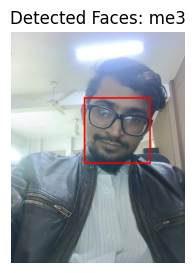

{
  "status": "matched",
  "person": "me3",
  "confidence": 0.65,
  "time_taken_sec": 2.134
}


In [10]:

import matplotlib.pyplot as plt

def recognize_face(input_image_file):
    start_time = time.time()

    known_faces, known_names = load_known_faces()
    if not known_faces:
        return {"status": "no_known_faces"}

    # Load input image
    input_image = face_recognition.load_image_file(input_image_file)

    # Step 1: Detect faces
    face_locations = face_recognition.face_locations(input_image, model="hog")
    if not face_locations:
        return {"status": "no_face_detected"}

    # Step 2: Encode detected faces
    input_encodings = face_recognition.face_encodings(input_image, known_face_locations=face_locations)
    if not input_encodings:
        return {"status": "encoding_failed"}

    # Step 3: Compare with known faces
    matched_person = None
    matched_confidence = None
    for input_encoding in input_encodings:
        known_faces_np = np.array(known_faces)
        distances = np.linalg.norm(known_faces_np - input_encoding, axis=1)

        best_match_index = distances.argmin()
        best_distance = distances[best_match_index]

        if best_distance < 0.50:
            matched_person = known_names[best_match_index]
            matched_confidence = round(1 - best_distance, 3)
            break

    display_image = input_image.copy()

    for (top, right, bottom, left) in face_locations:
        display_image[top:bottom, left:right] = cv2.rectangle(
            display_image[top:bottom, left:right].copy(),
            (0,0), (right-left, bottom-top),
            (255,0,0), 20
        )

    plt.figure(figsize=(3,3))
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Detected Faces: {matched_person if matched_person else 'Unknown'}")
    plt.show()

    if matched_person:
        return {
            "status": "matched",
            "person": matched_person,
            "confidence": matched_confidence,
            "time_taken_sec": round(time.time() - start_time, 3)
        }

    return {
        "status": "not_matched",
        "time_taken_sec": round(time.time() - start_time, 3)
    }


if __name__ == "__main__":
    if len(sys.argv) > 1:
        image_path = sys.argv[1]
        result = recognize_face("mudassir1.jpeg")
        print(json.dumps(result, indent=2))
    else:
        print("Usage: python script.py <image_path>")